In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
!wget $data

--2025-10-20 17:50:29--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-10-20 17:50:30 (1.09 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv("course_lead_scoring.csv")

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
categorical = ['lead_source', 'industry', 'employment_status','location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [9]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [11]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [17]:
from sklearn.metrics import roc_auc_score

In [20]:
auc_ls = roc_auc_score(y_train,df_train['lead_score'])
auc_cv = roc_auc_score(y_train,df_train['number_of_courses_viewed'])
auc_ic = roc_auc_score(y_train,df_train['interaction_count'])
auc_ai = roc_auc_score(y_train,df_train['annual_income'])

In [21]:
print(auc_ls)
print(auc_cv)
print(auc_ic)
print(auc_ai)

0.6144993577250176
0.7635680590007088
0.738270176293409
0.5519578313253012


In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
dv, model = train(df_train, y_train, C=1.0)

In [28]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
y_pred = predict(df_val, dv, model)

In [41]:
roc_auc_score(y_val,y_pred)

0.8171316268814112

In [31]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [33]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [34]:
df_scores[]

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,122,0,0,0.583618,1.000000
2,0.02,171,122,0,0,0.583618,1.000000
3,0.03,171,122,0,0,0.583618,1.000000
4,0.04,171,122,0,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544
97,0.97,1,0,170,122,1.000000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


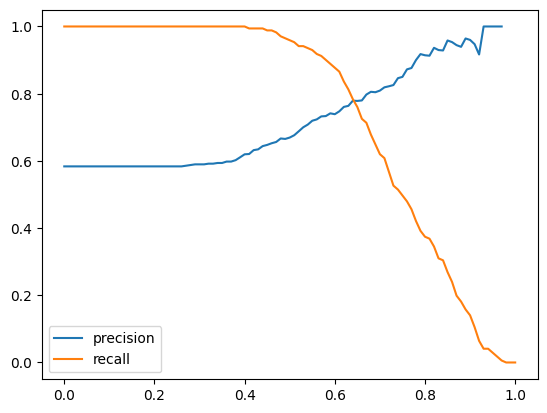

In [37]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')

plt.legend()

In [45]:
df_scores[df_scores['threshold'] == 0.65]

,threshold,tp,fp,fn,tn,precision,recall
65,0.65,130,37,41,85,0.778443,0.760234


In [46]:
df_scores['F1'] = 2 * ((df_scores['precision'] * df_scores['recall'])/(df_scores['precision'] + df_scores['recall']))

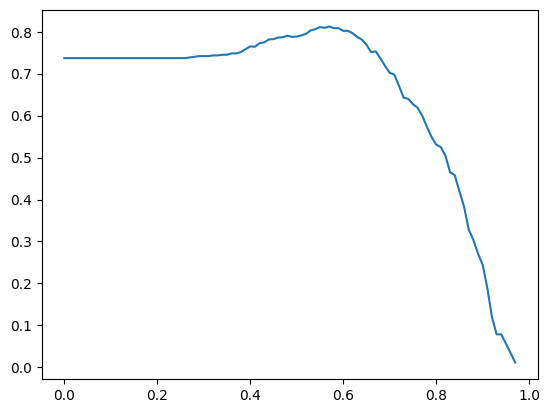

In [47]:
plt.plot(df_scores.threshold, df_scores['F1'])

In [49]:
df_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
98,referral,NA,1,56659.0,employed,asia,4,0.75,1
1188,social_media,education,2,66171.0,unemployed,north_america,2,0.66,0
1407,events,finance,1,66523.0,self_employed,europe,3,0.64,1
1083,social_media,finance,1,56746.0,student,north_america,3,0.98,0
404,referral,NA,0,55449.0,student,australia,4,0.47,0


In [51]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val   = df_full_train.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val   = df_val.converted.values
    
    # convert to dictionaries for DictVectorizer
    dicts_train = df_train.drop("converted", axis=1).to_dict(orient="records")
    dicts_val   = df_val.drop("converted", axis=1).to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts_train)
    X_val   = dv.transform(dicts_val)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("AUC scores:", scores)
print("Mean:", np.mean(scores))
print("Std:", np.std(scores))

AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean: 0.8221089148573075
Std: 0.03580711942905165


In [52]:
C_values = [0.000001, 0.001, 1.0]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val   = df_full_train.iloc[val_idx]

        y_train = df_train["converted"].values
        y_val   = df_val["converted"].values

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.drop(columns=["converted"]).to_dict(orient="records"))
        X_val   = dv.transform(df_val.drop(columns=["converted"]).to_dict(orient="records"))

        model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

# show table
print("C\t\tmean_auc\tstd_auc")
for C, m, s in results:
    print(f"{C}\t{m}\t\t{s}")

# pick best: highest mean, then lowest std, then smallest C
best = sorted(results, key=lambda r: (-r[1], r[2], r[0]))[0]
print("\nBest C:", best[0])

C		mean_auc	std_auc
1e-06	0.56		0.024
0.001	0.867		0.029
1.0	0.822		0.036

Best C: 0.001
